# Movies Analysis
    Ajay Dev - 04/04/2021

Performing PCA, Clustering, and SVD on movies.csv and ratings.csv

The goal is to cluster the users based on their movie ratings and genres.

Dataset: https://github.com/srviest/movie-recommender/tree/master/dataset/movielens/small

In [6]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from plotnine import *
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

In [7]:
df_ratings = pd.read_csv('ratings.csv')
df_movies = pd.read_csv('movies.csv')

# Transforming Data

Converting to user-movie rating matrix. (671 users and 9066 movies)

In [17]:
user_movie_df = df_ratings.pivot_table(index='userId', columns='movieId', values='rating', fill_value=0)
user_movie = user_movie_df.to_numpy()
print(user_movie)
print(user_movie.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [5. 0. 0. ... 0. 0. 0.]]
(671, 9066)


# Principle Component Analysis

Transpose and mean center the user-movie matrix.

In [19]:
user_movie_t = user_movie.T
user_movie_t_mean = np.subtract(user_movie_t, user_movie_t.mean())
user_movie_t_mean

array([[-0.05825388, -0.05825388, -0.05825388, ..., -0.05825388,
         3.94174612,  4.94174612],
       [-0.05825388, -0.05825388, -0.05825388, ..., -0.05825388,
        -0.05825388, -0.05825388],
       [-0.05825388, -0.05825388, -0.05825388, ..., -0.05825388,
        -0.05825388, -0.05825388],
       ...,
       [-0.05825388, -0.05825388, -0.05825388, ..., -0.05825388,
        -0.05825388, -0.05825388],
       [-0.05825388, -0.05825388, -0.05825388, ..., -0.05825388,
        -0.05825388, -0.05825388],
       [-0.05825388, -0.05825388, -0.05825388, ..., -0.05825388,
        -0.05825388, -0.05825388]])

Apply PCA to reduce movie dimensionality.

In [20]:
pca = PCA(n_components = 2)
principal_components = pca.fit_transform(user_movie_t_mean)
pc_df = pd.DataFrame(principal_components, columns=['PC1', 'PC2'])
pc_df

,PC1,PC2
0,39.475982,6.574505
1,14.589369,2.858308
2,4.257624,-1.533141
3,-1.106876,-0.476502
4,5.383068,-1.095143
...,...,...
9061,-2.192232,0.633710
9062,-1.737633,1.018110
9063,-2.352035,0.358787
9064,-2.365249,0.334555


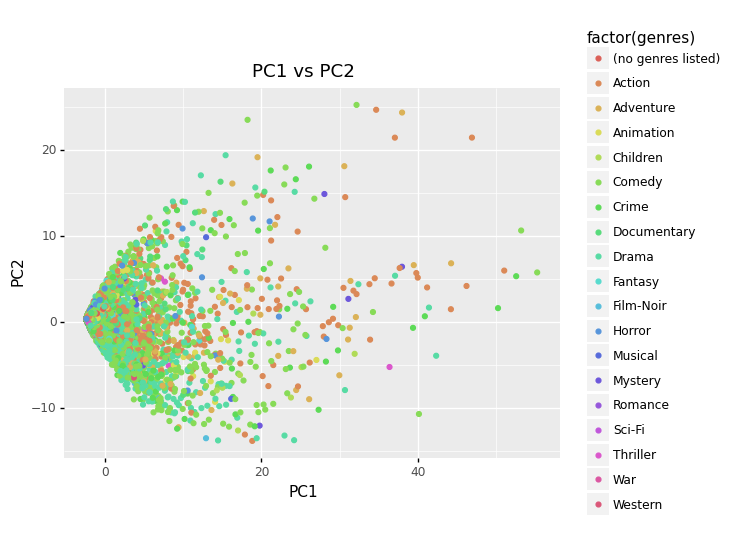

<ggplot: (8783904990507)>

In [24]:
final_pca = pc_df
final_pca['genres'] = df_movies['genres'].replace(regex=r"\|.*", value="")
ggplot(final_pca, aes(x='PC1', y='PC2', color='factor(genres)')) + geom_point() + ggtitle("PC1 vs PC2")

From the plot above, it appears most genres tend to cluster towards areas where PC1 and PC2 are lower. We can clearly see a funnel shape where PC1 < 10 and -10 < PC2 < 10. The genres that more spread out and outside of the funnel tend to be action, adventure, children, and comedy. The genres with the blue to pink colors tend to cluster very closely to each other. Overall, there seems to be a bit too much overlapping so it is very hard to make a clear distinction between the genres.

In [22]:
print("Total Variance of 2 Components:", sum(pca.explained_variance_ratio_))
pc_80variance = 2
for pc in range(175, 200):
    temp_pca = PCA(n_components = pc)
    temp_pca.fit_transform(user_movie_t_mean)
    x = sum(temp_pca.explained_variance_ratio_)
    if x > 0.8:
        pc_80variance = pc
        break
print("Components needed to explain at least 80% variance: ", pc_80variance)

Total Variance of 2 Components: 0.2087808048744308
Components needed to explain at least 80% variance:  177


From our results, we need at least 177 components to be able to explain 80% of the variance in our data. This is a lot higher than our previous k=2 components. When k=2, the first 2 principal components have a total of around 20.88% of the variance which is very low. If we use k=2 or 2 components, we would be losing a lot of our variance and information and overall the quality of our visualization would be lower. If we use 177 components instead of 2, we would tremendously improve the quality of our visualization as we would have more information and variance to represent our data.

# 3: Clustering

Choosing the appriate k and applying k-means clustering to the user-movie matrix.

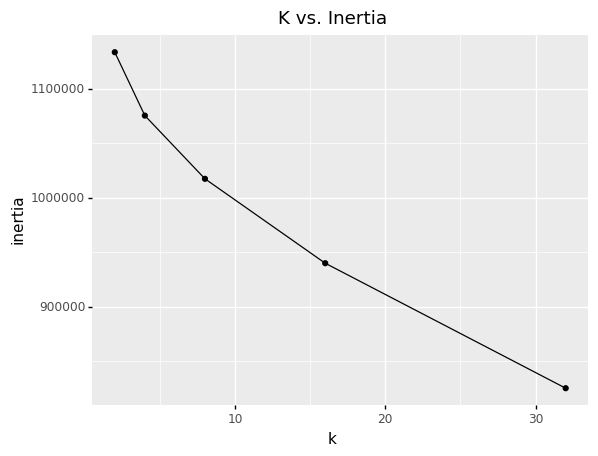

<ggplot: (8783846526118)>

In [26]:
k = [2, 4, 8, 16, 32]
inertia = []
for i in k:
    inertia.append(KMeans(i).fit(user_movie).inertia_)
    
k_inertia = pd.DataFrame({'k': k, 'inertia': inertia})
ggplot(k_inertia, aes(x='k', y='inertia')) + geom_line() + geom_point() + ggtitle("K vs. Inertia")

It is best to use k=8 as it appears to be the "elbow" of the plot and provides a good tradeoff between low inertia and small k value. K=16 provides a lower inertia but it also has double the k value (higher complexity). K=4 provides a lower complexity but it also has a much higher inertia.

In [28]:
user_movie_clust = user_movie_df
user_movie_clust['clusters'] = KMeans(8, random_state=369).fit_predict(user_movie_df)
means = user_movie_clust.groupby('clusters').mean().T
top3_in_cluster = {}
for i in range(8):
    top3_in_cluster[i+1] = list(means.nlargest(3, means.columns[i]).index)

for cluster, top_movies in top3_in_cluster.items():
    for i in range(3):
        top3_in_cluster[cluster][i] = df_movies[df_movies['movieId'] == top_movies[i]]['title'].iloc[0]

for cluster, top_movies in top3_in_cluster.items():
    print("Cluster:", cluster)
    print("Highest Rated Movies:")
    print("  ", top_movies[0])
    print("  ", top_movies[1])
    print("  ", top_movies[2])
    print("----------------------------------------")

Cluster: 1
Highest Rated Movies:
   Fargo (1996)
   Star Wars: Episode IV - A New Hope (1977)
   Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
----------------------------------------
Cluster: 2
Highest Rated Movies:
   Matrix, The (1999)
   Lord of the Rings: The Fellowship of the Ring, The (2001)
   Lord of the Rings: The Two Towers, The (2002)
----------------------------------------
Cluster: 3
Highest Rated Movies:
   Shawshank Redemption, The (1994)
   Pulp Fiction (1994)
   Forrest Gump (1994)
----------------------------------------
Cluster: 4
Highest Rated Movies:
   Sense and Sensibility (1995)
   Taxi Driver (1976)
   Flirting With Disaster (1996)
----------------------------------------
Cluster: 5
Highest Rated Movies:
   Toy Story (1995)
   Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
   Seven (a.k.a. Se7en) (1995)
----------------------------------------
Cluster: 6
Highest Rated Movies:
   Lord of the Rings: The Fellowship of the Ring, The (20

From the results of our current seeded clustering, there seems to be some reasonable grouping. Cluster 2 was able to group 2 of the movies from Lord of the Rings and had The Matrix at the top. It seems like this cluster has interests in action and maybe movie series. Cluster 6 was able to cluster Star Wars, The Matrix, and Lord of the Rings which shows that this may be a group of users that enjoy old sci-fi and action movies. Moving away from the action movies, it appears that cluster 7 was able to make a distinct group for thriller and drama. Overall there seems to be a fair grouping of movies and the cluster can make a distinction between action movies and dramas as seen on clusters 7 and 6. Unfortunately, it seems like there isn't enough distinction between all the clusters as some clusters (especially those with action movies) look very similar.

# 4: Singular Value Decomposition

Applying SVD on the user-movie matrix.

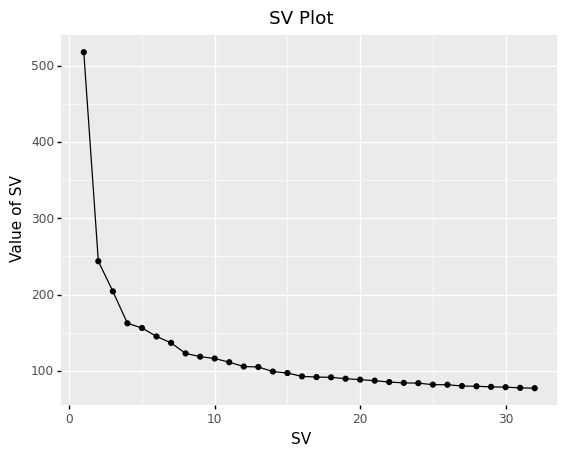

<ggplot: (8783845941965)>

In [29]:
U, S, Vt = np.linalg.svd(user_movie, full_matrices=False)
sv_df = pd.DataFrame({'Value of SV': S[:32], 'SV': list(range(1, 33))})
ggplot(sv_df, aes(x='SV', y='Value of SV')) + geom_point() + geom_line() + ggtitle("SV Plot")

{2: 0.1598005203429703, 4: 0.21218233325161062, 8: 0.27624784150899834, 16: 0.3489477886160135, 32: 0.4394377585153674}


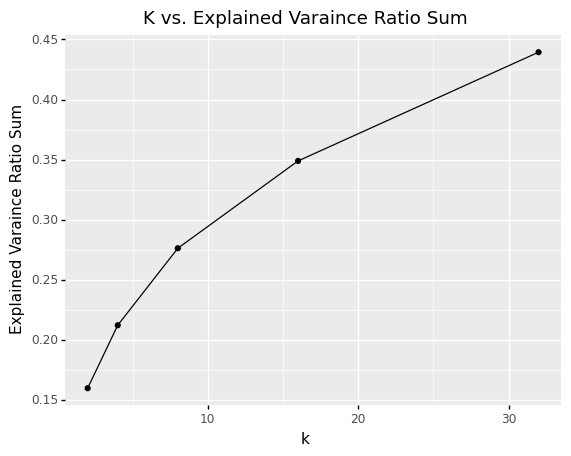

<ggplot: (8783829049176)>

In [30]:
kvals = [2,4,8,16,32]
sum_evr = {}
evr_list = []
for k in kvals:
    evr_list.append(sum(TruncatedSVD(k).fit(user_movie).explained_variance_ratio_))
    sum_evr[k] = sum(TruncatedSVD(k).fit(user_movie).explained_variance_ratio_)
print(sum_evr)
k_inertia = pd.DataFrame({'k': kvals, 'Explained Varaince Ratio Sum': evr_list})
ggplot(k_inertia, aes(x='k', y='Explained Varaince Ratio Sum')) + geom_line() + geom_point() + \
    ggtitle("K vs. Explained Varaince Ratio Sum")

Compared to the K vs. Inertia graph before, this K vs. Explained Varaince Ratio Sum graph has the opposite reaction. The inertia graph had a decaying reaction but this one is close to a logistic type growth. Here we can see that the ratio sum increases as the k value increases and the rate at which it increases also slowly decreases. 

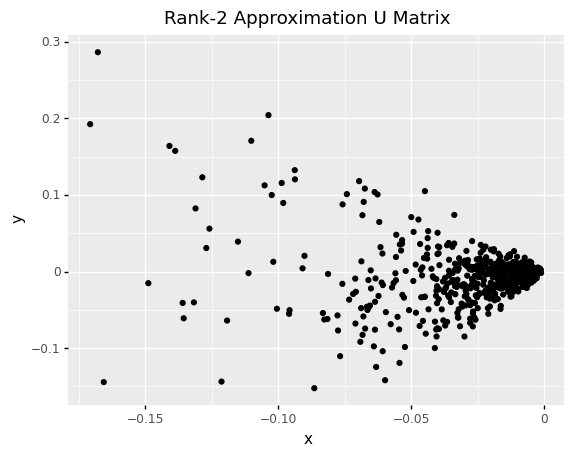

<ggplot: (8783846523892)>

In [31]:
rank2_U = np.matrix(U[:,:2])
rank2_U_df = pd.DataFrame(rank2_U, columns=["x", "y"])
rank2_U_df.index = list(range(1,672))
ggplot(rank2_U_df, aes(x='x', y='y')) + geom_point() + ggtitle("Rank-2 Approximation U Matrix")

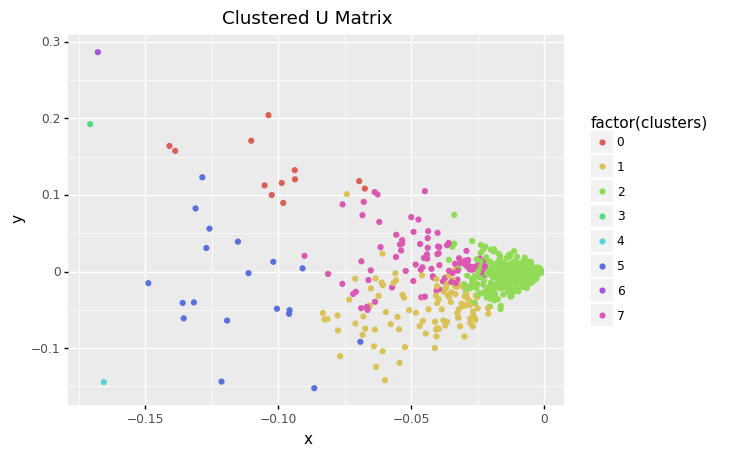

<ggplot: (8783829247037)>

In [32]:
rank2_U_df['clusters'] = user_movie_clust['clusters']
ggplot(rank2_U_df, aes(x='x', y='y', color='factor(clusters)')) + geom_point() + ggtitle("Clustered U Matrix")

Unlike our previous PCA graph and clustering, we can observe a clear distinction between the different clusters.

In our previous PCA plot where we had 2 principal components, it was very hard to create a division between the genres. Most of the genres overlapped each other and there was no clear trend.

When we used clustering, there appeared to be a bit more distinction between the clusters but there were a couple clusters that were hard to tell apart.

In our current SVD plot, we can see a clear distinction between the clusters when applying the same cluster values from the previous analysis. It appears that clusters 2 and 3 cluster very close to each other and funnel into the values where x and y reach 0. As we spread away from the funnel we notice more clusters that have a clear groupiung and less overlapping. For example, cluster 7 and 1 clearly occupy different areas of the graph and have very little overalapping. Again as we move away from the funnel, clustesr 0 and 5 occupy very disinct areas of the plot. There are a couple outliers such as cluster 6, 3, and 4 as they are away from their occupied area but overall, we can see a clear pattern and area of where these clusters occupy the plot.

Compared to our previous PCA and clustering method, this current plot gives us the best and most clear visual of the clusters. 